In [1]:
import sys
sys.path.append("../../src")

In [2]:
import os
import torch
import torchvision

import statistics
import h5py
import copy
import cv2
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage import measure

import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from util.train_methods import (GetLoader,
                                load_old_weights,
                                hard_binary_accuracy,
                                train,
                                test,
                                display_roc_curve,
                                gen_state_dict)
import util.constants

import tempfile
import time
import pickle as pkl;

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [3]:
n_epochs = 10
patience_limit = 20
patience = 0
batch_size_train = 16 # use 1 to make valid easier
batch_size_test = 16
learning_rate = 0.0005
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

model_path = '../saved_models/bbox_disease_classifier.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }


In [5]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3,
                 'Atelectasis': 4, 'Infiltration': 5, 'Pneumonia' : 6, 'Pneumothorax' : 7, 'No Finding': 8}

In [6]:
pkl_load = open('../data/dataset.pickle', 'rb')
data = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [7]:
transforms = [#torchvision.transforms.RandomHorizontalFlip(p=0.5),
              #torchvision.transforms.RandomAffine(5, translate=(0.1, 0.05), shear=0.1, scale=(0.001, 0.15)),
              #torchvision.transforms.RandomAffine(0, scale=(0.15, 0.15)),
              torchvision.transforms.ToTensor()]

# transforms = [torchvision.transforms.ToTensor()]
#transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
#0 = train, 1 = test
dataset_valid = GetLoader(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis',
                                                   'Infiltration', 'Pneumonia', 'Pneumothorax', 'No Finding']),
                          num_imgs, tt_factor, 1, transforms)

print(len(dataset_valid))

3920


In [8]:
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=16, shuffle=True, num_workers=4)
print(len(valid_loader))

245


In [9]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [10]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=9, bias=True),
    nn.Sigmoid()
])

model = torch.nn.DataParallel(model)
model.cuda();

In [11]:
path_multi = model_path

In [12]:
model.load_state_dict(gen_state_dict(model_path))

<All keys matched successfully>

In [13]:
model.eval();

best vals: 0.5150835711373829
best vals: 0.47220698283055457
best vals: 0.39340696506896367
best vals: 0.3408833934686176
best vals: 0.3506390148335891
best vals: 0.23628913231583176
best vals: 0.29278794402583425
best vals: 0.4971536231230046
best vals: 0.4721520467836257


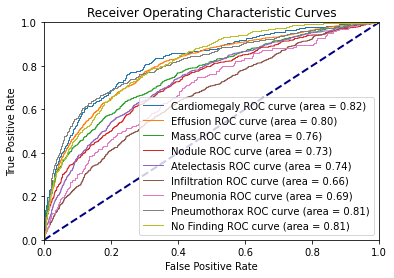

best thresholds:
{'Cardiomegaly': 0.020983250811696053, 'Effusion': 0.054538335651159286, 'Mass': 0.0566093847155571, 'Nodule': 0.08178110420703888, 'Atelectasis': 0.023930028080940247, 'Infiltration': 0.13815227150917053, 'Pneumonia': 0.005487028509378433, 'Pneumothorax': 0.10205517709255219, 'No Finding': 0.4392490088939667}


In [14]:
display_roc_curve(valid_loader, model, dis_small_map, batch_size_test)